In [1]:
# import the required libraries
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, StringIndexer
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [3]:
# reads the train data
us_train_cat = spark.read.csv(get_training_filename('USAccident_train_categorical.csv'), header = True, inferSchema = True)

In [4]:
# reads the test data
us_test_cat = spark.read.csv(get_training_filename('USAccident_validation_categorical.csv'), header = True, inferSchema = True)

In [5]:
# creates a vector assembler
va = VectorAssembler().setInputCols([i for i in us_train_cat.columns if i!='Severity']).setOutputCol('features')

In [6]:
# creates a string indexer
label_stringIdx = StringIndexer(inputCol="Severity", outputCol="label")

Below we convert the multiclass data into binary data

In [7]:
us_train_cat=us_train_cat.withColumn("Severity",when(((us_train_cat["Severity"]==4) | (us_train_cat["Severity"]==3)),1).otherwise(0))

In [8]:
us_test_cat=us_test_cat.withColumn("Severity",when(((us_test_cat["Severity"]==4) | (us_test_cat["Severity"]==3)),1).otherwise(0))

In [9]:
# Creating the evaluator for our binary classification
evaluator_rfb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# RF Base Model

In [10]:
# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Train model with Training Data
rfModel = Pipeline(stages=[label_stringIdx,va, rf])

In [11]:
rf_fit = rfModel.fit(us_train_cat)

In [12]:
print("AUC ROC score:",evaluator_rfb.evaluate(rf_fit.transform(us_test_cat)))

AUC ROC score: 0.7634901876492165


In [13]:
# Prints the accuracy of our binary classification
true_labels=us_test_cat.toPandas()["Severity"]
evaluator_rfb.evaluate(rf_fit.transform(us_test_cat))
binary_prediction=rf_fit.transform(us_test_cat).select("prediction").collect()
binary_true_labels=us_test_cat.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.6892473173146102


In [19]:
rf_fit.stages[-1].getMaxDepth()

5

In [26]:
rf_fit.stages[-1].getNumTrees

20

In [27]:
rf_fit.stages[-1].getImpurity()

'gini'

In [14]:
# tranforming the test data for predictions
prediction_rfb=(rf_fit.transform(us_test_cat)).toPandas()["prediction"]

In [15]:
# storing the true labels for evaluation purpose below
true_labels=us_test_cat.toPandas()["Severity"]

In [16]:
print(classification_report(y_pred=prediction_rfb,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81    131571
           1       0.73      0.09      0.16     64408

   micro avg       0.69      0.69      0.69    195979
   macro avg       0.71      0.54      0.48    195979
weighted avg       0.70      0.69      0.59    195979



In [17]:
# create a dataframe to print the feature importance
pd.set_option('display.max_rows', None)
feat_imp_tuned_rf = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], rf_fit.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

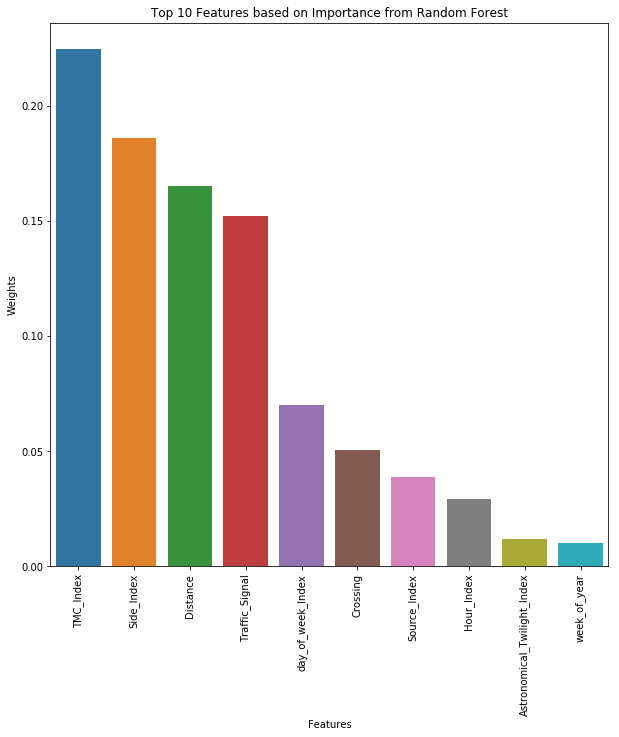

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rf['column'][:10], y=feat_imp_tuned_rf['weight'][:10],data=feat_imp_tuned_rf)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest");

# RF Grid Search 

In [19]:
# Create an initial RandomForest model.
rf_new = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Train model with Training Data
rfModel_new = Pipeline(stages=[label_stringIdx,va, rf_new])

#paramGrid_rft = ParamGridBuilder().addGrid(rf_new.numTrees, [10, 30, 60]).addGrid(rf_new.maxDepth, [3, 5, 10]).addGrid(rf_new.impurity,["entropy", "gini"]).build()
paramGrid_rft = ParamGridBuilder().addGrid(rf_new.numTrees, [60]).addGrid(rf_new.maxDepth, [10]).addGrid(rf_new.impurity,["gini"]).build()

In [20]:
# creating a cross validator for tuning our model
cv_rf = CrossValidator(estimator=rfModel_new, estimatorParamMaps=paramGrid_rft, evaluator=evaluator_rfb, numFolds=5).fit(us_train_cat)

In [21]:
# store the predictions from our test set
pred_rft = cv_rf.transform(us_test_cat)

In [22]:
print("ROC AUC sccore:",evaluator_rfb.evaluate(pred_rft))

ROC AUC sccore: 0.7880870240899686


In [23]:
# Printing the accuracy of our binary predictions
true_labels=us_test_cat.toPandas()["Severity"]
evaluator_rfb.evaluate(pred_rft)
binary_prediction=pred_rft.select("prediction").collect()
binary_true_labels=us_test_cat.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.7257971517356452


In [20]:
cv_rf.bestModel.stages[-1].getMaxDepth()

10

In [22]:
cv_rf.bestModel.stages[-1].getNumTrees

60

In [24]:
cv_rf.bestModel.stages[-1].getImpurity()

'gini'

In [24]:
cv_rf.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_deb569e64636', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_deb569e64636', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_deb569e64636', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_deb569e64636', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_deb569e64636', 

In [25]:
# storing the predictions of our test set
prediction_rft=pred_rft.toPandas()["prediction"]

In [26]:
# storing the true labels of our test set
true_labels=us_test_cat.toPandas()["Severity"]

In [27]:
print(classification_report(y_pred=prediction_rft,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82    131571
           1       0.66      0.34      0.45     64408

   micro avg       0.73      0.73      0.73    195979
   macro avg       0.70      0.63      0.63    195979
weighted avg       0.71      0.73      0.70    195979



In [28]:
# Creates a Dataframe of feature importances from our model
pd.set_option('display.max_rows', None)
feat_imp_tuned_rfg = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cv_rf.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

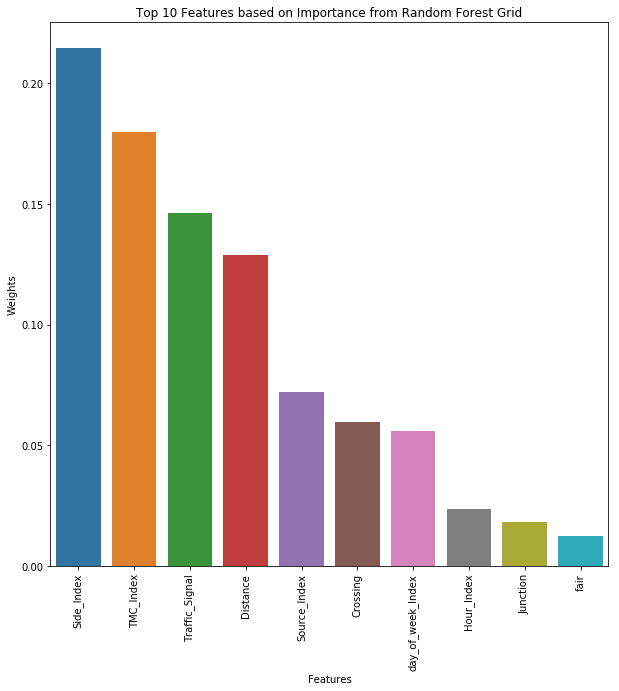

In [29]:
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rfg['column'][:10], y=feat_imp_tuned_rfg['weight'][:10],data=feat_imp_tuned_rfg)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest Grid");

# GBT Base Model

In [30]:
# Declares the gbt classifier model
gbt = GBTClassifier(seed=42)

In [31]:
# Creates a pipeline for our model
gbt_pipe = Pipeline(stages=[label_stringIdx, va, gbt])

In [32]:
# Fits the pipeline on our train data
gbtModel = gbt_pipe.fit(us_train_cat)

In [33]:
print("ROC AUC Score:",evaluator_rfb.evaluate(gbtModel.transform(us_test_cat)))

ROC AUC Score: 0.787408211157604


In [34]:
# Calculates the accuracy of our model
true_labels=us_test_cat.toPandas()["Severity"]
evaluator_rfb.evaluate(gbtModel.transform(us_test_cat))
binary_prediction=gbtModel.transform(us_test_cat).select("prediction").collect()
binary_true_labels=us_test_cat.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.7289046275366238


In [ ]:
gbtModel.stages[-1].getMaxDepth()

In [40]:
gbtModel.stages[-1].getStepSize()

0.1

In [41]:
gbtModel.stages[-1].getMaxIter()

20

In [35]:
# Predict on test data
prediction_gbtn=gbtModel.transform(us_test_cat).toPandas()["prediction"]

In [36]:
# Stores the true labels from our test data
true_labels=us_test_cat.toPandas()["Severity"]

In [37]:
print(classification_report(y_pred=prediction_gbtn,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81    131571
           1       0.63      0.43      0.51     64408

   micro avg       0.73      0.73      0.73    195979
   macro avg       0.69      0.65      0.66    195979
weighted avg       0.72      0.73      0.71    195979



In [38]:
# Create a dataframe for our feature importances
pd.set_option('display.max_rows', None)
feat_imp_tuned_gtbb = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], gbtModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

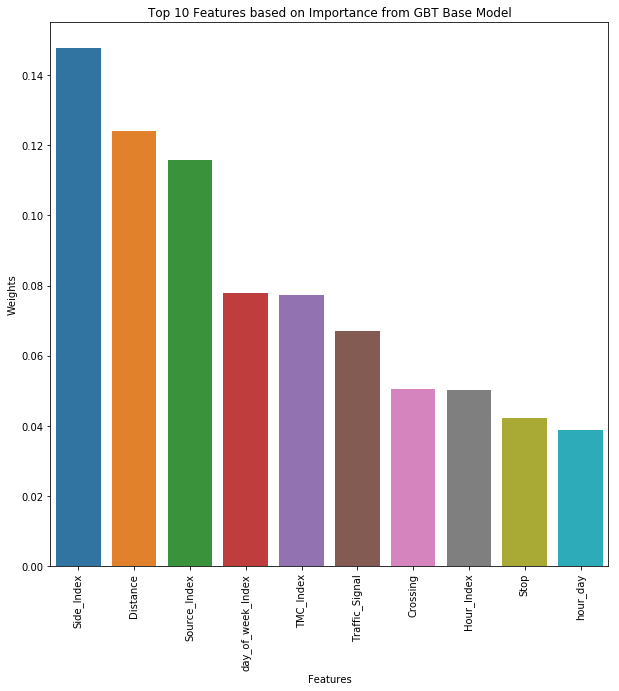

In [39]:
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_gtbb['column'][:10], y=feat_imp_tuned_gtbb['weight'][:10],data=feat_imp_tuned_gtbb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from GBT Base Model");

# GBT Binary Tuned Best Model

In [40]:
# Create a GBT Classifier
gbt_t_new = GBTClassifier(maxIter=55,seed=42)
gbt_pipe_t_new = Pipeline(stages=[label_stringIdx, va, gbt_t_new])

# Create a evaluator for our model
evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# Create grid for tuning the model
#grid_gbt_t_new = ParamGridBuilder().addGrid(gbt_t_new.stepSize, [0.1,0.3,0.01]).addGrid(gbt_t_new.maxDepth, [3, 5, 8]).build()
grid_gbt_t_new = ParamGridBuilder().addGrid(gbt_t_new.stepSize, [0.3]).addGrid(gbt_t_new.maxDepth, [8]).build()
cv1_gbt_t_new = CrossValidator(estimator=gbt_pipe_t_new,estimatorParamMaps=grid_gbt_t_new, numFolds=5, evaluator=evaluator,seed=42)

In [41]:
# fit the cross validation model
cvModel_gbt_t_new = cv1_gbt_t_new.fit(us_train_cat)

In [42]:
print("ROC AUC Score:",evaluator_rfb.evaluate(cvModel_gbt_t_new.transform(us_test_cat)))

ROC AUC Score: 0.8032377340351009


In [43]:
# calculates the accuracy of the binary model
true_labels=us_test_cat.toPandas()["Severity"]
evaluator_rfb.evaluate(cvModel_gbt_t_new.transform(us_test_cat))
binary_prediction=cvModel_gbt_t_new.transform(us_test_cat).select("prediction").collect()
binary_true_labels=us_test_cat.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.7407885538756703


In [68]:
cvModel_gbt_t_new.bestModel.stages[-1].getMaxDepth()

8

In [69]:
cvModel_gbt_t_new.bestModel.stages[-1].getStepSize()

0.3

In [45]:
cvModel_gbt_t_new.bestModel.stages[-1].extractParamMap()

{Param(parent='GBTClassifier_34f6d1b395a8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_34f6d1b395a8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_34f6d1b395a8', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_34f6d1b395a8', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_34f6d1b395a8', name='labelCol', doc='label column name'): 'la

In [46]:
# Stores the prediction from ourr test set
prediction_gbt_t_new=cvModel_gbt_t_new.transform(us_test_cat).toPandas()["prediction"]

In [47]:
# Stores the true labels from our test set
true_labels=us_test_cat.toPandas()["Severity"]

In [48]:
print(classification_report(y_pred=prediction_gbt_t_new,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82    131571
           1       0.63      0.50      0.56     64408

   micro avg       0.74      0.74      0.74    195979
   macro avg       0.71      0.68      0.69    195979
weighted avg       0.73      0.74      0.73    195979



In [49]:
# Create a dataframe of feature importances
pd.set_option('display.max_rows', None)
feat_imp_tuned_gbt_t_new = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cvModel_gbt_t_new.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

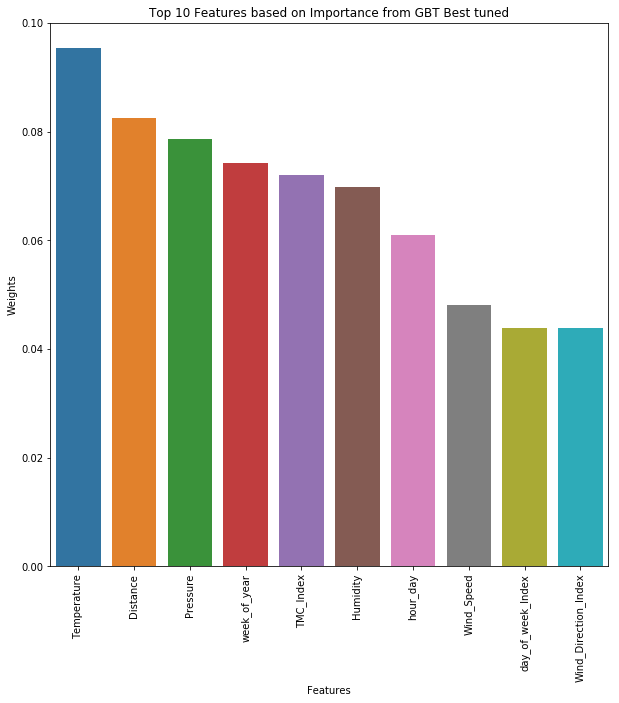

In [50]:
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_gbt_t_new['column'][:10], y=feat_imp_tuned_gbt_t_new['weight'][:10],data=feat_imp_tuned_gbt_t_new)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from GBT Best tuned");

# Decision Trees Binary Classification Base Model

In [51]:
# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",seed=42)

# Creates a pipeline
dt_pipe = Pipeline(stages=[label_stringIdx, va, dt])

# Train model with Training Data
dtModel = dt_pipe.fit(us_train_cat)

In [52]:
# Makes prediction from our test set
pred_dt = dtModel.transform(us_test_cat)

In [53]:
# prints the ROC AUC score
print("ROC AUC:",evaluator.evaluate(pred_dt))

ROC AUC: 0.6639903304724255


In [203]:
dtModel.stages[-1].getMaxDepth()

5

In [204]:
dtModel.stages[-1].getMinInstancesPerNode()

1

In [205]:
dtModel.stages[-1].getMaxBins()

32

In [54]:
# calculates the accuracy of our model
evaluator.evaluate(pred_dt)

binary_prediction=pred_dt.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.7156021818664244


In [55]:
prediction_dtb=pred_dt.toPandas()["prediction"]

In [56]:
true_labels=us_test_cat.toPandas()["Severity"]

In [57]:
print(classification_report(y_pred=prediction_dtb,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81    131571
           1       0.61      0.37      0.46     64408

   micro avg       0.72      0.72      0.72    195979
   macro avg       0.68      0.63      0.63    195979
weighted avg       0.70      0.72      0.69    195979



In [58]:
pd.set_option('display.max_rows', None)
feat_imp_tuned_dtb= pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

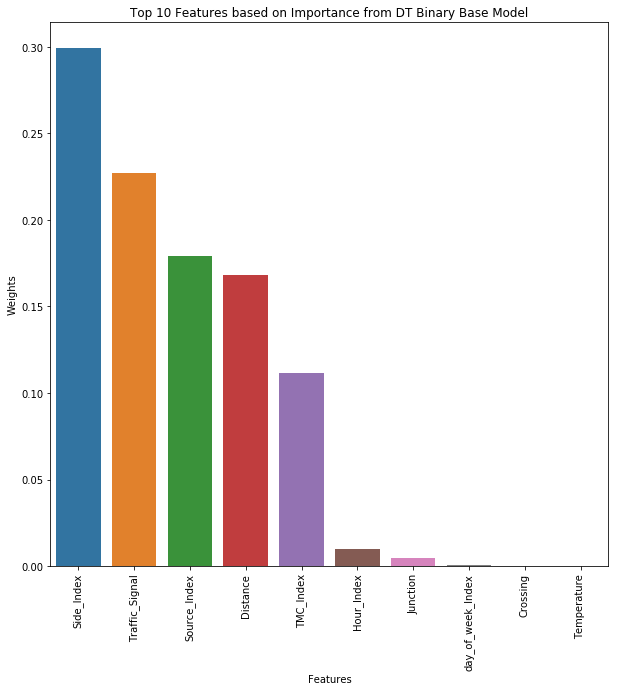

In [59]:
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dtb['column'][:10], y=feat_imp_tuned_dtb['weight'][:10],data=feat_imp_tuned_dtb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Binary Base Model");

# Decision Tree Binary Classification Grid Search

In [60]:
# declares a decision tree classifier
dt_new = DecisionTreeClassifier(labelCol="label", featuresCol="features")

dt_new_pipe = Pipeline(stages=[label_stringIdx, va, dt_new])

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

#grid_dt = ParamGridBuilder().addGrid(dt_new.maxDepth, [10,15,30]).addGrid(dt_new.minInstancesPerNode, [500,1000,1500]).addGrid(dt_new.maxBins,[20,35,50]).build()
grid_dt = ParamGridBuilder().addGrid(dt_new.maxDepth, [10]).addGrid(dt_new.minInstancesPerNode, [500]).addGrid(dt_new.maxBins,[50]).build()

cv1_dt = CrossValidator(estimator=dt_new_pipe,estimatorParamMaps=grid_dt, numFolds=5, evaluator=evaluator)

In [61]:
dtModel_t = cv1_dt.fit(us_train_cat)

In [62]:
pred_dtt = dtModel_t.transform(us_test_cat)

In [63]:
print("AUC ROC:",evaluator.evaluate(pred_dtt))

AUC ROC: 0.5687880524415173


In [64]:
# calculates the accuracy 
evaluator.evaluate(pred_dtt)

binary_prediction=pred_dtt.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.7307313538695472


In [65]:
dtModel_t.bestModel.stages[-1].extractParamMap()

{Param(parent='DecisionTreeClassifier_6cf0199ad377', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_6cf0199ad377', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_6cf0199ad377', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeClassifier_6cf0199ad377', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='DecisionTreeClassifier_6cf0199ad377', name='labelCol', doc='label column name'): 'lab

In [179]:
dtModel_t.bestModel.stages[-1].getMaxDepth()

10

In [180]:
dtModel_t.bestModel.stages[-1].getMinInstancesPerNode()

500

In [181]:
dtModel_t.bestModel.stages[-1].getMaxBins()

50

In [66]:
prediction_dtbt=pred_dtt.toPandas()["prediction"]

In [67]:
true_labels=us_test_cat.toPandas()["Severity"]

In [68]:
from sklearn.metrics import classification_report

In [69]:
print(classification_report(y_pred=prediction_dtbt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81    131571
           1       0.61      0.49      0.54     64408

   micro avg       0.73      0.73      0.73    195979
   macro avg       0.69      0.67      0.68    195979
weighted avg       0.72      0.73      0.72    195979



In [70]:
pd.set_option('display.max_rows', None)
feat_imp_tuned_dtbt= pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel_t.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

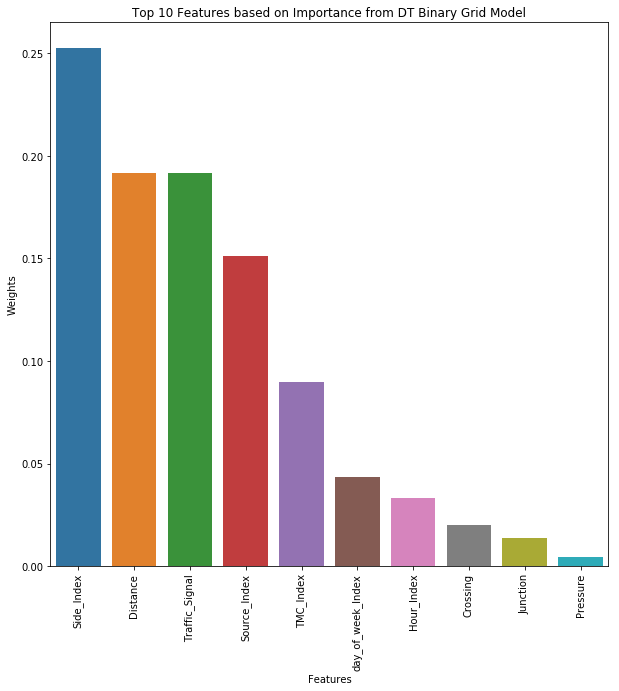

In [71]:
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dtbt['column'][:10], y=feat_imp_tuned_dtbt['weight'][:10],data=feat_imp_tuned_dtbt)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Binary Grid Model");